In [ ]:
import pandas as pd
import os
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
from collections import Counter
from collections import defaultdict

In [21]:
# Juntar todos los csv que srapeamos en una carpeta

folder_path = '/Users/samuelmarzano/Documentos/PAPER/NEWSPAPER DATA'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in csv_files], ignore_index=True)


In [22]:
#Limpiarlos

df['TEXTO'] = df['TEXTO'].str.replace('\n\n', ' ', regex=False)
df['TEXTO'] = df['TEXTO'].str.replace('\n', ' ', regex=False)
df['TEXTO'] = df['TEXTO'].astype(str)
df = df[df['TEXTO'] != 'nan']

In [ ]:
#Luego se pueden añadir a los datos completos

# DATA ANALYSIS IN LOCATION TERMS

In [14]:
# Abrimos el dataset completo y filtramos por paises y tipos deseados
df = pd.read_csv('full_data.csv')
excluded_countries = ['Venezuela', 'Peru', 'Bolivia', 'Ecuador', 'Uruguay']
df = df[~df['PAÍS'].isin(excluded_countries)]
news = df[~df['FUENTE'].str.contains(r'r/', na=False)]

In [16]:
# Aqui se separan los bloques en textos de X longitud

nltk.download('punkt')

target_word_count = 75

def split_text_into_chunks(text, target_words=75):
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = ''
    current_count = 0

    for sentence in sentences:
        word_count = len(word_tokenize(sentence))
        if current_count + word_count <= target_words:
            current_chunk += ' ' + sentence
            current_count += word_count
        else:
            if current_chunk:
                chunks.append(current_chunk.strip())
            current_chunk = sentence
            current_count = word_count

    if current_chunk:
        chunks.append(current_chunk.strip())

    return chunks

rows = []

for _, row in news.iterrows():
    chunks = split_text_into_chunks(row['TEXTO'], target_word_count)
    for chunk in chunks:
        rows.append({
            'TEXTO': chunk,
            'PAÍS': row['PAÍS'],
            'FUENTE': row['FUENTE']
        })

news_expanded = pd.DataFrame(rows)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samuelmarzano/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Estudio de palabras geografícas

In [12]:
# Cargar el modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")

geo_words = []

# Procesar cada texto en la columna TEXTO
for texto in news_expanded["TEXTO"].dropna():
    doc = nlp(texto)
    for ent in doc.ents:
        if ent.label_ in ["LOC", "GPE"]:  # LOC: lugar; GPE: entidad geopolítica (país, ciudad, región)
            # Convertir a minúsculas y agregar
            geo_words.append(ent.text.lower())

# Contar frecuencias
geo_costs = dict(Counter(geo_words))


/var/folders/6j/rlnpvg4s5jv0zxykz_s464s80000gn/T/ipykernel_26147/526438195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frecuencia", y="Lugar", data=top_geo_df, palette="viridis")


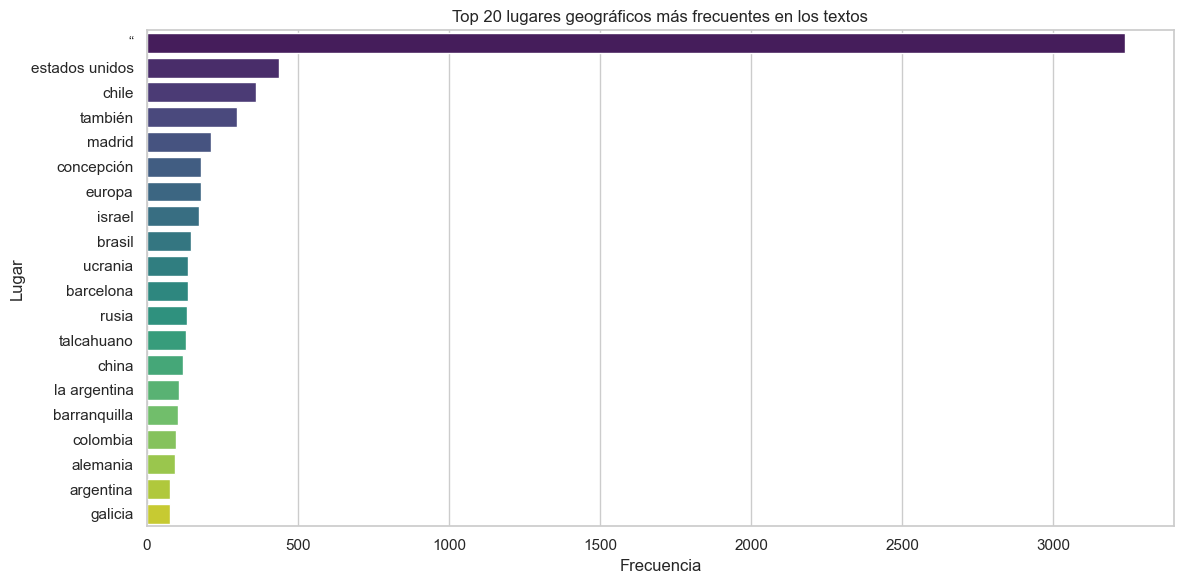

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir el diccionario a un DataFrame
geo_df = pd.DataFrame(list(geo_costs.items()), columns=["Lugar", "Frecuencia"])

# Ordenar por frecuencia descendente
geo_df = geo_df.sort_values(by="Frecuencia", ascending=False)

# Elegir los N más frecuentes (por ejemplo, 20)
top_n = 20
top_geo_df = geo_df.head(top_n)

# Estilo de Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Crear gráfica de barras
sns.barplot(x="Frecuencia", y="Lugar", data=top_geo_df, palette="viridis")

plt.title(f"Top {top_n} lugares geográficos más frecuentes en los textos")
plt.xlabel("Frecuencia")
plt.ylabel("Lugar")
plt.tight_layout()
plt.show()


/var/folders/6j/rlnpvg4s5jv0zxykz_s464s80000gn/T/ipykernel_26147/1729097285.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(labels), ax=axes[idx], palette="viridis")
/var/folders/6j/rlnpvg4s5jv0zxykz_s464s80000gn/T/ipykernel_26147/1729097285.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(labels), ax=axes[idx], palette="viridis")
/var/folders/6j/rlnpvg4s5jv0zxykz_s464s80000gn/T/ipykernel_26147/1729097285.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(labels)

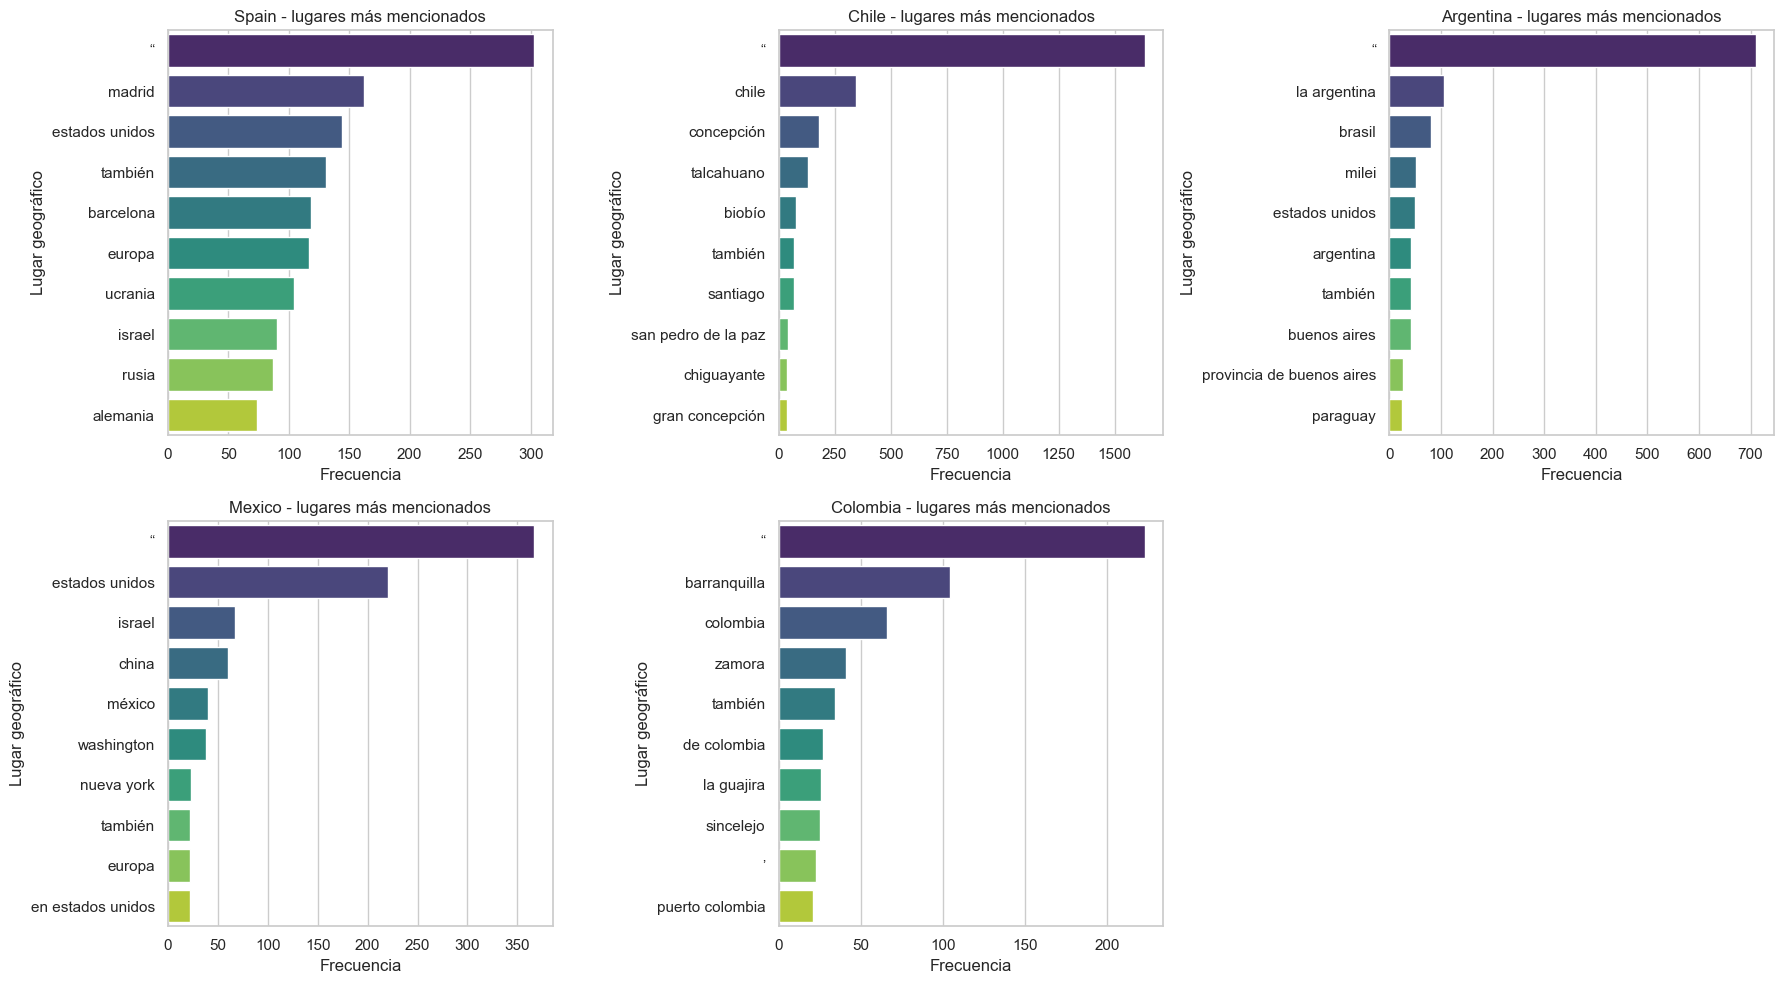

In [21]:
# Cargar modelo spaCy
nlp = spacy.load("es_core_news_sm")

# Asegurar solo los 5 países más frecuentes o seleccionados manualmente
top_paises = news_expanded["PAÍS"].dropna().value_counts().head(5).index.tolist()

# Diccionario: país -> lista de entidades geográficas
geo_words_by_country = {pais: [] for pais in top_paises}

# Procesar textos
for _, row in news_expanded.dropna(subset=["TEXTO", "PAÍS"]).iterrows():
    pais = row["PAÍS"].strip()
    if pais in top_paises:
        doc = nlp(row["TEXTO"])
        for ent in doc.ents:
            if ent.label_ in ["GPE", "LOC"]:
                geo_words_by_country[pais].append(ent.text.lower())

# Crear subplots (grid 2x3 por ejemplo si hay 5 países)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, pais in enumerate(top_paises):
    word_counts = Counter(geo_words_by_country[pais]).most_common(10)  # top 10
    if not word_counts:
        continue
    labels, counts = zip(*word_counts)
    
    sns.barplot(x=list(counts), y=list(labels), ax=axes[idx], palette="viridis")
    axes[idx].set_title(f"{pais} - lugares más mencionados")
    axes[idx].set_xlabel("Frecuencia")
    axes[idx].set_ylabel("Lugar geográfico")

# Quitar eje vacío si hay menos de 6
for j in range(len(top_paises), 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
